In [1]:
import gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
import wandb
import random
import time
import pickle 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import numpy as np
import os
import cv2

from PIL import Image
from collections import namedtuple, deque
from itertools import count

from models.on_track_cls import OnTrackClsNet
from models.rl_car_racing import DQN
from dp_spec.img import preprocess_img
from dp_util.img import load_img, output_to_arr
from dp_util.dqn import ReplayMemory, find_eps_thres
from dp_spec.dqn import optimize_model, select_action
from cfgs.rl_car_racing import RlCarRacingCfg

C:\Users\auyin11\anaconda3\envs\rl_game_pip\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_prev_md = False

step_waiting = 50
on_track_cls_file = 'on_track_classifier_v_2_0_5.pth'
img_num = 1
dir_auto_img = r'D:\file\data\racing\auto_img'
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))
collect_img = False

In [3]:
cfg = RlCarRacingCfg(test_mode=False, dir_data='./')

wandb.init(project=cfg.project, entity=cfg.entity,
           group=f'{cfg.user}_{cfg.model}', job_type="train",
           name= cfg.version)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: auyin11 (kaggle_winner). Use `wandb login --relogin` to force relogin


device: cuda


In [4]:
# load the on track classifier model and encoder
with open('ont_hot_encoder.pkl', 'rb') as f:
    encoder = pickle.load(f)     
# extract definition of prediction output
on_track_label = encoder.categories_[0].tolist().index('on')
off_track_label = encoder.categories_[0].tolist().index('off')

on_track_cls_net = OnTrackClsNet().to(device)
on_track_cls_net.load_state_dict(torch.load(on_track_cls_file))

C:\Users\auyin11\anaconda3\envs\rl_game_pip\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<All keys matched successfully>

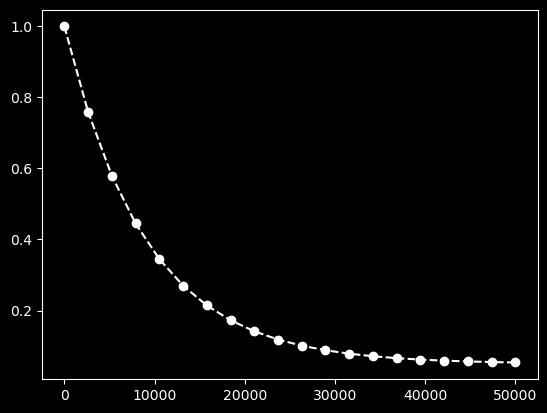

In [5]:
# preview the eps threshold
list_steps_done = np.linspace(1, 50000, num=20)
list_eps_threshold = []

for x in list_steps_done:
    list_eps_threshold.append(find_eps_thres(cfg, x))

plt.style.use('dark_background')    
plt.plot(list_steps_done, list_eps_threshold, c ="white", linestyle='dashed', marker='o')

In [6]:
env = gym.make("CarRacing-v2", render_mode='human', continuous=False)

n_actions = env.action_space.n

state_dim = (2, 84, 84)
input_size = state_dim[1]

policy_net = DQN(state_dim[0], input_size, n_actions).to(device)
target_net = DQN(state_dim[0], input_size, n_actions).to(device)
optimizer = optim.AdamW(policy_net.parameters(), lr=cfg.LR, amsgrad=True)

In [7]:
if load_prev_md:
    print(f'load the previous model {cfg.md_name.split(".")[0]}')
    
    policy_net.load_state_dict(torch.load(f'poli_{cfg.md_name}'))
    target_net.load_state_dict(torch.load(f'tg_{cfg.md_name}'))

    with open(f"dict_cp_{cfg.md_name.split('.')[0]}.pkl", 'rb') as f:
        dict_cp = pickle.load(f)  
        
    memory = dict_cp['memory']
    list_reward_round_sum = dict_cp['list_reward_round_sum']
    list_round_avg_loss = dict_cp['list_round_avg_loss']
    steps_done = dict_cp['steps_done']
    i_episode = dict_cp['i_episode']
    eps_threshold = dict_cp['eps_threshold']
    
# start from a new records
else:
    print('start to train a new model')
    target_net.load_state_dict(policy_net.state_dict())
    
    memory = ReplayMemory(cfg.MEMORY_CAP)
    list_reward_round_sum = []
    list_round_avg_loss = []
    steps_done = 0
    i_episode = 1
    eps_threshold = cfg.EPS_START

start to train a new model


In [8]:
while i_episode <= cfg.NUM_EPISODES:
    
    steps_done_round = 0
    list_reward_round = []
    list_loss_round = []
    print(f'i_episode: {i_episode}, eps_threshold: {eps_threshold:.{cfg.SF}f}')
    
    state, info = env.reset()
    prev_state = None

    # as the image is zooming in the first 50 steps and it wil affect learning, do not interact with env
    for i in range(step_waiting):
        _, _, _, _, _ = env.step(0)
        steps_done_round += 1
        
    state = preprocess_img(state)
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    
    for t in count():
        
        steps_done += 1
        steps_done_round += 1
        eps_threshold = find_eps_thres(cfg, steps_done)
        
        if prev_state is None:
            prev_state = state
        states = torch.concat((prev_state, state)).unsqueeze(0)
        action = select_action(policy_net, states, eps_threshold)
        observation, reward, terminated, truncated, _ = env.step(action)
        
        # increase the positive reward to encourage using gas
        if reward > 0:
            reward = reward * 3.5
        
        # if off track, penalise
        with torch.no_grad():
            outputs = on_track_cls_net(state.unsqueeze(0))
        on_off_track = output_to_arr(outputs)[0]
        if on_off_track == off_track_label:
            reward -= 0.1
        
        # save the img to train a on track classifier model
        if collect_img:            
            img_num += 1
            if img_num % 10 == 0:
                img = Image.fromarray(observation, 'RGB')
                img.save(os.path.join(dir_auto_img, f'{img_num}.png'))
        
        list_reward_round.append(reward)
        
        reward = torch.tensor([reward], device=device)
        observation = preprocess_img(observation)
        next_state = torch.tensor(observation,
                                      dtype=torch.float32, device=device).unsqueeze(0)
        done = terminated or truncated
        # Store the transition in memory
        next_states = torch.concat((state, next_state)).unsqueeze(0)
        memory.push(states, action, next_states, reward)
        prev_state = state
        state = next_state
        
        if len(memory) >= 3000:
            if len(memory) == 3000:
                print('start to train model')
            # Perform one step of the optimization (on the policy network)
            loss = optimize_model(policy_net, target_net, memory, optimizer,
                                  cfg.BATCH_SIZE, cfg.GAMMA, device)
            list_loss_round.append(loss)
        
        if steps_done % 10 == 0:
            # Soft update of the target network's weights
            # θ′ ← τ θ + (1 −τ )θ′
            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*cfg.TAU \
                    + target_net_state_dict[key]*(1-cfg.TAU)
            target_net.load_state_dict(target_net_state_dict)
        
        if done:
            sum_reward_round = np.sum(list_reward_round)
            list_reward_round_sum.append(sum_reward_round)
            avg_loss_round = np.mean([x.cpu().detach().numpy() for x in list_loss_round])
            list_round_avg_loss.append(avg_loss_round)
            wandb.log({"reward_round": sum_reward_round, 'avg_loss_round': avg_loss_round})
            
            i_episode += 1
            
            break

i_episode: 1, eps_threshold: 1.00000


C:\Users\auyin11\anaconda3\envs\rl_game_pip\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
C:\Users\auyin11\anaconda3\envs\rl_game_pip\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\auyin11\anaconda3\envs\rl_game_pip\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


i_episode: 2, eps_threshold: 0.90483
i_episode: 3, eps_threshold: 0.81920
i_episode: 4, eps_threshold: 0.74214
start to train model


C:\Users\auyin11\anaconda3\envs\rl_game_pip\lib\site-packages\torch\nn\modules\loss.py:912: UserWarning: Using a target size (torch.Size([48, 1])) that is different to the input size (torch.Size([48, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


i_episode: 5, eps_threshold: 0.67281
i_episode: 6, eps_threshold: 0.61042
i_episode: 7, eps_threshold: 0.55428
i_episode: 8, eps_threshold: 0.50376
i_episode: 9, eps_threshold: 0.45831
i_episode: 10, eps_threshold: 0.41740
i_episode: 11, eps_threshold: 0.38060
i_episode: 12, eps_threshold: 0.34748
i_episode: 13, eps_threshold: 0.31768
i_episode: 14, eps_threshold: 0.29087
i_episode: 15, eps_threshold: 0.26674
i_episode: 16, eps_threshold: 0.24503
i_episode: 17, eps_threshold: 0.22549
i_episode: 18, eps_threshold: 0.20791
i_episode: 19, eps_threshold: 0.19209
i_episode: 20, eps_threshold: 0.17786
i_episode: 21, eps_threshold: 0.16505
i_episode: 22, eps_threshold: 0.15352
i_episode: 23, eps_threshold: 0.14315
i_episode: 24, eps_threshold: 0.13382
i_episode: 25, eps_threshold: 0.12542
i_episode: 26, eps_threshold: 0.11787
i_episode: 27, eps_threshold: 0.11107
i_episode: 28, eps_threshold: 0.10495
i_episode: 29, eps_threshold: 0.09945
i_episode: 30, eps_threshold: 0.09449
i_episode: 31, ep

KeyboardInterrupt: 

In [9]:
env.close()

In [ ]:
stop

In [10]:
torch.save(policy_net.state_dict(), f'poli_{cfg.md_name}')
torch.save(target_net.state_dict(), f'tg_{cfg.md_name}')

dict_cp = {
    'memory': memory,
    'list_reward_round_sum': list_reward_round_sum,
    'list_round_avg_loss': list_round_avg_loss,
    'steps_done': steps_done,
    'i_episode': i_episode,
    'eps_threshold': eps_threshold
}

with open(f"dict_cp_{cfg.md_name.split('.')[0]}.pkl",'wb') as output:
      pickle.dump(dict_cp, output)

<Axes: >

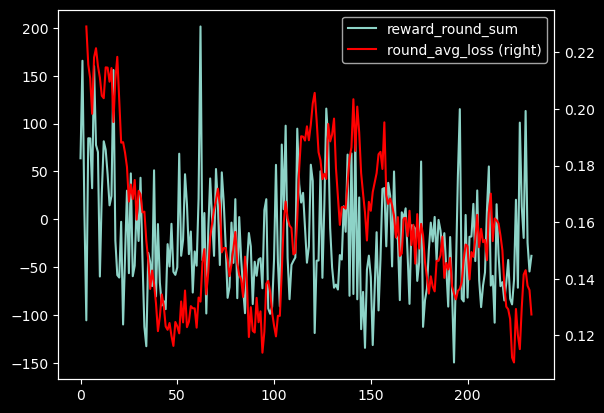

In [11]:
import pandas as pd
df_reward_round_sum = pd.DataFrame(
    {'reward_round_sum': list_reward_round_sum,
    'round_avg_loss': list_round_avg_loss
    })

ax = df_reward_round_sum.reward_round_sum.plot(legend=True)
df_reward_round_sum.round_avg_loss.plot(ax=ax,
                                        color='r',secondary_y=True, legend=True)